In [1]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import sys
%matplotlib inline

#### Loading the dataset

In [2]:
d = np.load("/Users/nipun/Downloads/data-2013-2017-missing.npy").item()

#### Finding homes occuring across both years

In [3]:
np.intersect1d(list(d[2016].keys()), list(d[2015].keys())).size

214

In [4]:
np.intersect1d(list(d[2017].keys()), list(d[2016].keys())).size

153

I would be choosing 2015 and 2016 as the successive years

In [5]:
use_homes = np.intersect1d(list(d[2016].keys()), list(d[2015].keys()))

In [6]:
use_homes

array([  26,   59,   77,   86,   93,   94,  101,  114,  187,  434,  484,
        499,  503,  545,  624,  744,  781,  871,  946,  974, 1086, 1103,
       1169, 1192, 1202, 1283, 1403, 1415, 1463, 1500, 1507, 1589, 1617,
       1632, 1642, 1697, 1700, 1718, 1790, 1800, 1953, 2018, 2094, 2129,
       2156, 2171, 2199, 2233, 2365, 2378, 2472, 2532, 2557, 2575, 2638,
       2755, 2787, 2814, 2818, 2829, 2859, 2945, 2953, 2965, 3009, 3039,
       3044, 3134, 3268, 3310, 3367, 3392, 3456, 3482, 3500, 3527, 3538,
       3577, 3649, 3778, 3829, 3831, 3849, 3916, 3918, 3935, 3967, 4031,
       4154, 4213, 4220, 4297, 4298, 4336, 4342, 4352, 4357, 4373, 4375,
       4473, 4514, 4641, 4767, 4874, 4946, 4957, 4998, 5026, 5060, 5129,
       5218, 5275, 5317, 5357, 5403, 5545, 5568, 5677, 5718, 5785, 5809,
       5814, 5874, 5889, 5921, 5949, 5959, 5972, 6061, 6063, 6121, 6139,
       6165, 6348, 6412, 6423, 6460, 6498, 6691, 6692, 6730, 6990, 7016,
       7030, 7361, 7390, 7429, 7504, 7536, 7560, 76

In [7]:
APPLIANCE_ORDER = ['use','air1','dishwasher1','furnace1','kitchenapp1','microwave1','refrigerator1']

In [8]:
t = np.empty((len(use_homes), len(APPLIANCE_ORDER), 2*12))

In [9]:
t[:] = np.NaN

In [10]:
for i, home in enumerate(use_homes):
    for j, appliance in enumerate(APPLIANCE_ORDER):
        try:
            t[i, j, :12] = d[2016][home][appliance].values
            t[i, j, 12:] = d[2017][home][appliance].values
        except:
            print(home, i, "Could not be processed")

59 1 Could not be processed
59 1 Could not be processed
59 1 Could not be processed
77 2 Could not be processed
77 2 Could not be processed
77 2 Could not be processed
77 2 Could not be processed
77 2 Could not be processed
77 2 Could not be processed
77 2 Could not be processed
86 3 Could not be processed
86 3 Could not be processed
94 5 Could not be processed
94 5 Could not be processed
101 6 Could not be processed
101 6 Could not be processed
101 6 Could not be processed
101 6 Could not be processed
101 6 Could not be processed
101 6 Could not be processed
101 6 Could not be processed
187 8 Could not be processed
187 8 Could not be processed
187 8 Could not be processed
187 8 Could not be processed
187 8 Could not be processed
187 8 Could not be processed
187 8 Could not be processed
484 10 Could not be processed
484 10 Could not be processed
484 10 Could not be processed
484 10 Could not be processed
484 10 Could not be processed
484 10 Could not be processed
484 10 Could not be pr

9942 211 Could not be processed
9942 211 Could not be processed
9942 211 Could not be processed
9942 211 Could not be processed
9942 211 Could not be processed
9942 211 Could not be processed
9942 211 Could not be processed
9971 212 Could not be processed
9971 212 Could not be processed
9971 212 Could not be processed
9971 212 Could not be processed
9982 213 Could not be processed
9982 213 Could not be processed
9982 213 Could not be processed
9982 213 Could not be processed
9982 213 Could not be processed
9982 213 Could not be processed
9982 213 Could not be processed


In [11]:
def factorise(tensor, r, random_seed=0, num_iter=400, eps=1e-8, lr=1):
    np.random.seed(random_seed)
    args_num = [1, 2, 3]

    def cost(tensor, home, appliance,  month):
        pred = np.einsum('Hr, Ar, Tr ->HAT', home, appliance, month)
        mask = ~np.isnan(tensor)
        error = (pred - tensor)[mask].flatten()
        return np.sqrt((error ** 2).mean())

    mg = grad(cost, argnum=args_num)
    sizes = [(x, r) for x in tensor.shape]
    home = np.random.rand(*sizes[0])
    appliance = np.random.rand(*sizes[1])
    month = np.random.rand(*sizes[2])

    sum_home = np.zeros_like(home)
    sum_appliance = np.zeros_like(appliance)
    sum_month = np.zeros_like(month)

    # GD procedure
    for i in range(num_iter):
        del_home, del_appliance, del_month = mg(tensor, home, appliance, month)

        sum_home += eps + np.square(del_home)
        lr_home = np.divide(lr, np.sqrt(sum_home))
        home -= lr_home * del_home

        sum_appliance += eps + np.square(del_appliance)
        lr_appliance = np.divide(lr, np.sqrt(sum_appliance))
        appliance -= lr_appliance * del_appliance

        sum_month += eps + np.square(del_month)
        lr_month = np.divide(lr, np.sqrt(sum_month))
        month -= lr_month * del_month

        
        # Projection to non-negative space
        home[home < 0] = 1e-8
        appliance[appliance < 0] = 1e-8
        month[month < 0] = 1e-8

        if i % 500 == 0:
            print(cost(tensor, home, appliance, month), i)
            sys.stdout.flush()

    return home, appliance, month

#### Creating the baseline 

In [46]:
e.iloc[170:][:, APPLIANCE_ORDER[1:], :]

<class 'pandas.core.panel.Panel'>
Dimensions: 44 (items) x 6 (major_axis) x 24 (minor_axis)
Items axis: 8086 to 9982
Major_axis axis: air1 to refrigerator1
Minor_axis axis: 0 to 23

In [50]:
test_set[:, APPLIANCE_ORDER[1:], :]

AttributeError: 'Panel' object has no attribute 'set'

In [72]:
test_set = t[170:].copy()
test_set[:, 1:, :] = np.NaN
train_pool_set = t[:170].copy()
train_set = t[:10].copy()
pool_set = t[10:170].copy()
pool_homes = use_homes[10:170]

train_test_set = np.vstack([train_set, test_set])

In [73]:
h, a, m =factorise(train_test_set, 4)
pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)

1321.06734709 0


In [181]:
pred_df_only_train = {}
gt_df = {}
for month in range(13, 25):
    print(month)
    print("*"*20)
    h, a, m =factorise(train_test_set[:, :, :month], 3)
    pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
    pred_df_only_train[month] = pred[len(train_set):,1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)
    gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)

13
********************
1328.11532556 0
14
********************
1316.04696244 0
15
********************
1301.77674437 0
16
********************
1290.29684158 0
17
********************
1286.24206876 0
18
********************
1299.5060248 0
19
********************
1331.13362147 0
20
********************
1346.70981673 0
21
********************
1342.97076173 0
22
********************
1331.55399882 0
23
********************
1320.33749122 0
24
********************
1322.22358213 0


In [182]:
error_only_train = {month:(pd.DataFrame(pred_df_only_train[month]) - pd.DataFrame(gt_df[month])).abs().mean() for month in range(13, 25)}

In [183]:
pd.DataFrame(error_only_train)

,13,14,15,16,17,18,19,20,21,22,23,24
0,177.999075,99.224648,106.163852,101.999421,158.151351,269.481850,278.378996,260.300456,246.783852,213.739454,248.951540,275.645218
1,12.677185,14.189241,16.849066,14.637306,15.071170,15.801015,19.582428,14.541055,10.640007,10.156488,10.357987,15.210139
2,133.605689,78.868277,82.277710,96.749086,95.636346,116.465207,135.342942,118.896311,99.654345,70.776380,74.419170,154.268050
3,9.480593,10.796670,10.373167,10.943151,11.921941,11.174785,10.612149,8.929275,9.571104,9.480545,7.810574,10.630001
4,13.349202,8.155940,7.204757,8.800377,6.216182,7.508911,8.098851,7.401990,7.092130,6.176986,6.036245,15.784230
5,40.360994,41.837981,43.806948,37.769034,44.573735,52.677413,56.795399,54.902374,53.651722,49.440802,49.926992,46.242233


#### Randomly adding 5 homes every month from Pool

In [184]:
np.concatenate([pool_remove[x] for x in range(0, 2)]).shape

(10, 7, 24)

In [185]:
month = 13
pool_set_iter = {0:pool_set.copy()}
pred_df_random = {}
pool_remove_ix = {}
pool_remove = {}



for cur_iteration, month in enumerate(range(13, 25)):
    
    pool_remove_ix[cur_iteration] = np.random.choice(range(len(pool_set_iter[cur_iteration])), size=5)
    pool_remove[cur_iteration] = pool_set_iter[cur_iteration][pool_remove_ix[cur_iteration]]

    # We have data only 
    pool_remove[cur_iteration][:, 1:, :month-1] = np.NaN
    pool_train_test = np.concatenate((np.concatenate([pool_remove[x] for x in range(0, cur_iteration+1)]), train_test_set[:, :, :] ))

    h, a, m =factorise(pool_train_test[:, :, :month], 3)
    print(cur_iteration, month, len(pool_train_test))
    pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
    pred_df_random[month] = pred[len(train_set)+len(pool_remove[cur_iteration]):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
    gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)
    pool_set_iter[cur_iteration+1] = pool_set.copy()

1324.55591722 0
0 13 59
1311.17002532 0
1 14 64
1286.79678437 0
2 15 69
1271.10373734 0
3 16 74
1264.62631954 0
4 17 79
1262.9202476 0
5 18 84
1277.22317625 0
6 19 89
1294.05912149 0
7 20 94
1302.08186705 0
8 21 99
1274.60628488 0
9 22 104
1261.66313939 0
10 23 109
1250.12436265 0
11 24 114


In [186]:
(pd.DataFrame(pred_df_only_train[24])-pd.DataFrame(gt_df[24])).abs().mean()

0    275.645218
1     15.210139
2    154.268050
3     10.630001
4     15.784230
5     46.242233
dtype: float64

In [187]:
random_error = {}
fixed_train_error = {}
for month in range(13, 25):
    random_error[month] = (pd.DataFrame(pred_df_random[month])-pd.DataFrame(gt_df[month])).abs().mean()
    fixed_train_error[month] = (pd.DataFrame(pred_df_only_train[month])-pd.DataFrame(gt_df[month])).abs().mean()

In [188]:
import matplotlib.pyplot as plt

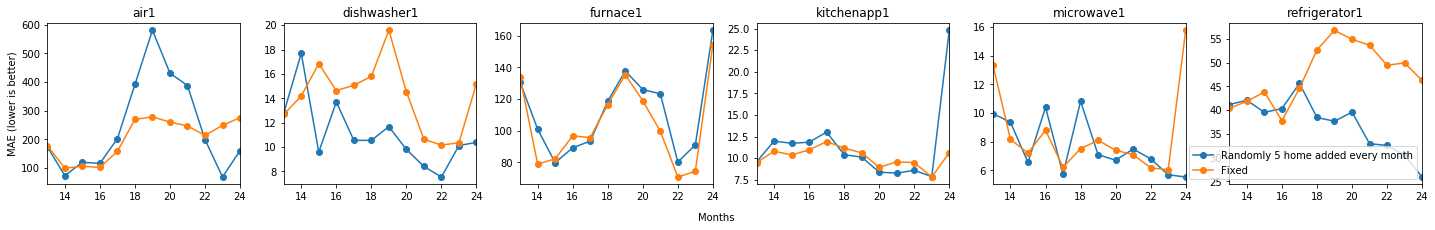

In [232]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 3), sharey=False)
for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
    pd.DataFrame(random_error).iloc[i].plot(label='Randomly 5 home added every month', ax=ax[i], marker='o')
    pd.DataFrame(fixed_train_error).iloc[i].plot(label='Fixed',ax=ax[i], marker='o')
    
    
    ax[i].set_title(appliance)
ax[0].set_ylabel("MAE (lower is better)")
plt.legend()
fig.text(0.5, -0.04, 'Months', ha='center')
plt.tight_layout()
plt.savefig("/Users/nipun/Desktop/random-fixed.pdf")

In [132]:
pd.DataFrame(random_error)

,13,14,15,16,17,18,19,20,21,22,23,24
0,164.899432,65.875815,89.282658,128.500687,204.518318,362.140985,530.625786,431.893676,350.462546,160.865451,73.655497,101.655121
1,13.607135,15.911772,7.608099,10.497091,10.962436,11.928530,13.717612,11.322272,6.285753,4.507973,5.566935,7.600178
2,134.182717,96.578707,79.542759,94.849684,105.860542,121.715809,138.115315,132.471167,116.312655,77.790759,77.535128,175.949207
3,8.713098,11.999694,12.625702,12.566697,13.881503,12.613547,11.249169,9.300507,9.235572,9.094643,8.851057,14.057309
4,8.010552,9.384215,6.685456,9.262203,5.296974,10.606590,10.881560,10.010111,8.556767,6.480508,6.373204,10.287288
5,42.098783,39.489453,36.903883,37.474465,43.584810,35.922245,36.460575,41.059711,41.504525,39.133515,37.971256,35.988724


In [143]:
pd.DataFrame(fixed_train_error)

,13,14,15,16,17,18,19,20,21,22,23,24
0,161.482838,73.845551,75.183428,92.582103,122.950039,205.819198,239.368046,222.683204,221.792051,138.470078,53.475452,230.409021
1,14.250157,15.336121,16.277641,15.203608,16.045159,17.002683,17.365376,15.427255,10.673293,12.068454,14.450456,10.863676
2,136.653426,88.335150,96.322872,114.539908,88.484429,93.265862,120.462149,113.090903,90.908113,63.924609,69.322344,160.041237
3,9.630549,10.748054,10.664591,11.393636,12.386338,13.213771,11.596133,9.210959,9.380288,9.532351,9.154239,11.058284
4,14.389491,7.862289,7.158323,8.678555,6.345381,7.754361,10.698949,9.446452,7.611801,6.555847,6.212393,15.094477
5,38.967145,40.274935,42.931951,41.766151,42.694789,39.007114,41.297077,42.932636,44.898987,41.564343,35.108840,35.059685


In [228]:
month = 13
pool_set_iter = {0:pool_set.copy()}
pred_df_active = {}
pool_remove_ix = {}
pool_remove = {}



for cur_iteration, month in enumerate(range(13, 15)):
    
    #pool_remove_ix[cur_iteration] = np.random.choice(range(len(pool_set_iter[cur_iteration])), size=5)
    #pool_remove[cur_iteration] = pool_set_iter[cur_iteration][pool_remove_ix[cur_iteration]]
    #np.concatenate([pool_remove[x] for x in range(0, cur_iteration+1)]),
    psc = pool_set.copy()
    psc[:, 1:, :] = np.NaN
    # We have data only 
    #pool_remove[cur_iteration][:, 1:, :month-1] = np.NaN
    pool_train_test = np.concatenate((psc,  train_test_set[:, :, :] ))
    pred_t_month = {}
    for rank in range(2, 6):
        h_t, a_t, m_t =factorise(pool_train_test[:, :, :month], rank)
        print(cur_iteration, month, len(pool_train_test))
        pred_t = np.einsum('Hr, Ar, Tr ->HAT', h_t, a_t, m_t)
        pred_t_month[rank] = pred_t[:len(psc), 1:, -1]
    #pred_df_active[month] = pred[len(psc)+len(train_set)+len(pool_remove[cur_iteration]):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
    #gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)
    #pool_set_iter[cur_iteration+1] = pool_set.copy()

1456.36041152 0
0 13 214
1453.80786265 0
0 13 214
1452.90828783 0
0 13 214
1450.69601724 0
0 13 214
1437.26199931 0
1 14 214
1434.78033652 0
1 14 214
1433.84672497 0
1 14 214
1431.61269403 0
1 14 214


In [229]:
o = {}
for appliance_num, appliance in enumerate(APPLIANCE_ORDER[1:]):
    o[appliance] = {}
    for rank in range(2, 6):
        o[appliance][rank] = pd.DataFrame(pred_t_month[rank])[appliance_num]

In [230]:
pd.DataFrame(o['air1']).std(axis=1).sort_values(ascending=False)

73     169.641227
31     166.188404
20     162.759639
74     147.193506
132    146.881178
9      133.141245
118    119.009116
142    117.523422
14     112.605401
27     109.633730
3      108.304792
126    107.762211
21     106.652032
159    102.702382
28     101.901782
124    100.391640
152     99.264264
117     97.664767
55      97.650820
136     97.300493
95      94.756827
60      94.515984
64      92.852821
32      92.835539
127     91.874496
96      90.789402
151     89.007273
92      88.611438
39      86.899728
138     84.977808
          ...    
104     36.330128
63      36.154352
149     34.394161
11      33.844375
86      33.725808
49      32.203501
100     31.940480
22      31.778697
91      30.263278
82      30.032812
135     29.839627
12      29.093418
36      27.930065
69      25.670703
146     24.063218
61      23.943915
122     22.265554
4       21.660217
19      21.553778
50      21.278889
7       21.133909
0       21.096065
23      20.345879
144     19.435188
52      18

In [191]:
random_error = {}
fixed_train_error = {}
active_error = {}
for month in range(13, 25):
    random_error[month] = (pd.DataFrame(pred_df_random[month])-pd.DataFrame(gt_df[month])).abs().mean()
    fixed_train_error[month] = (pd.DataFrame(pred_df_only_train[month])-pd.DataFrame(gt_df[month])).abs().mean()
    active_error[month] = (pd.DataFrame(pred_df_active[month])-pd.DataFrame(gt_df[month])).abs().mean()

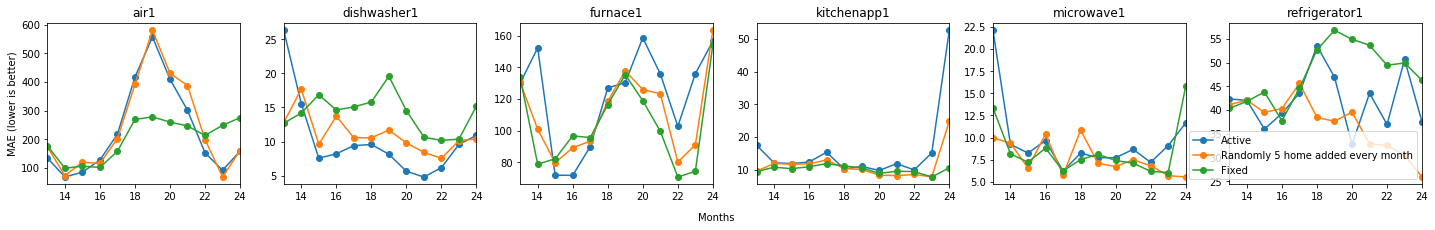

In [192]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 3), sharey=False)
for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
    pd.DataFrame(active_error).iloc[i].plot(label='Active', ax=ax[i], marker='o')


    pd.DataFrame(random_error).iloc[i].plot(label='Randomly 5 home added every month', ax=ax[i], marker='o')
    pd.DataFrame(fixed_train_error).iloc[i].plot(label='Fixed',ax=ax[i], marker='o')
    
    
    ax[i].set_title(appliance)
ax[0].set_ylabel("MAE (lower is better)")
plt.legend()
fig.text(0.5, -0.04, 'Months', ha='center')
plt.tight_layout()

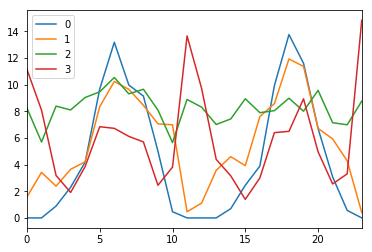

In [53]:
pd.DataFrame(m).plot()

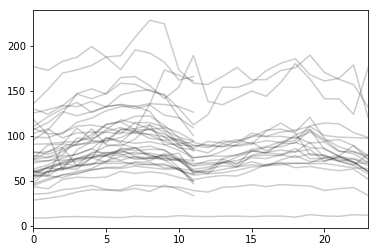

In [107]:
pd.DataFrame(t[:50, 6, :]).T.plot(legend=False, color='k',alpha=0.2)

In [80]:
d[2016][home]['air1']

localhour
2016-01       0.013665
2016-02      28.853880
2016-03      66.723450
2016-04     194.265945
2016-05     376.959076
2016-06     843.653625
2016-07    1115.922119
2016-08     963.244507
2016-09     845.506348
2016-10     524.622192
2016-11     140.937119
2016-12      26.517406
Name: air1, dtype: float32

In [71]:
i=0
home = use_homes[i]


In [73]:
%matplotlib inline

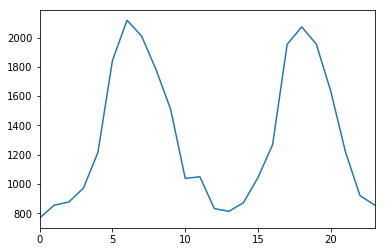

In [76]:
pd.Series(t[0, 0,]).plot()